In [1]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
rand_state = 42
tf.set_random_seed(rand_state)
np.random.seed(rand_state)

from skimage import exposure
import cv2
import glob
import time
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:
%%bash
if [ -d "./hot-dog-not-hot-dog/" ] 
then
    echo "Directory hot-dog-not-hot-dog exists." 
else
    unzip -qq hot-dog-not-hot-dog.zip -d ./hot-dog-not-hot-dog/
    echo "hot-dog-not-hot-dog.zip unzipped!"
fi

Directory hot-dog-not-hot-dog exists.


In [3]:
def rotateImage(img, angle):
    (rows, cols, ch) = img.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), angle, 1)
    return cv2.warpAffine(img, M, (cols,rows))
    
    
def loadBlurImg(path, imgSize):
    img = cv2.imread(path)
    angle = np.random.randint(0, 360)
    img = rotateImage(img, angle)
    img = cv2.blur(img,(5,5))
    img = cv2.resize(img, imgSize)
    return img

def loadImgClass(classPath, classLable, classSize, imgSize):
    x = []
    y = []
    
    for path in classPath:
        img = loadBlurImg(path, imgSize)        
        x.append(img)
        y.append(classLable)
        
    while len(x) < classSize:
        randIdx = np.random.randint(0, len(classPath))
        img = loadBlurImg(classPath[randIdx], imgSize)
        x.append(img)
        y.append(classLable)
        
    return x, y

def loadData(img_size, classSize, hotdogs, notHotdogs):    
    imgSize = (img_size, img_size)
    xHotdog, yHotdog = loadImgClass(hotdogs, 0, classSize, imgSize)
    xNotHotdog, yNotHotdog = loadImgClass(notHotdogs, 1, classSize, imgSize)
    print("There are", len(xHotdog), "hotdog images")
    print("There are", len(xNotHotdog), "not hotdog images")
    
    X = np.array(xHotdog + xNotHotdog)
    y = np.array(yHotdog + yNotHotdog)
    
    return X, y

def toGray(images):
    # rgb2gray converts RGB values to grayscale values by forming a weighted sum of the R, G, and B components:
    # 0.2989 * R + 0.5870 * G + 0.1140 * B 
    # source: https://www.mathworks.com/help/matlab/ref/rgb2gray.html
    
    images = 0.2989*images[:,:,:,0] + 0.5870*images[:,:,:,1] + 0.1140*images[:,:,:,2]
    return images

def normalizeImages(images):
    # use Histogram equalization to get a better range
    # source http://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_hist
    images = (images / 255.).astype(np.float32)
    
    for i in range(images.shape[0]):
        images[i] = exposure.equalize_hist(images[i])
    
    images = images.reshape(images.shape + (1,)) 
    return images

def preprocessData(images):
    grayImages = toGray(images)
    return normalizeImages(grayImages)

In [4]:
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

size = 32
classSize = 20000


hotdogs = glob.glob('./hot-dog-not-hot-dog/train/hot_dog/**/*.jpg', recursive=True) + \
glob.glob('./hot-dog-not-hot-dog/test/hot_dog/**/*.jpg', recursive=True) 

notHotdogs = glob.glob('./train/not_hot_dog/**/*.jpg', recursive=True) + \
glob.glob('./hot-dog-not-hot-dog/test/not_hot_dog/**/*.jpg', recursive=True)

scaled_X, y = loadData(size, classSize, hotdogs, notHotdogs)
scaled_X = preprocessData(scaled_X)
y = to_categorical(y)


n_classes=2
print("y shape", y.shape)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, 
                                                    test_size=0.2, 
                                                    random_state=rand_state)

print("train shape X", X_train.shape)
print("train shape y", y_train.shape)
print("Test shape X:", X_test.shape)
print("Test shape y: ", y_test.shape)

inputShape = (size, size, 1)

There are 20000 hotdog images
There are 20000 not hotdog images
y shape (40000, 2)
train shape X (32000, 32, 32, 1)
train shape y (32000, 2)
Test shape X: (8000, 32, 32, 1)
Test shape y:  (8000, 2)


In [5]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [6]:
import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization


model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=inputShape))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])



model.summary()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)  

In [7]:
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath='model.h5', monitor='val_acc', save_best_only=True)]

start = time.time()
history = model.fit(X_train, y_train,
                      batch_size=64,
                      epochs=50, 
                      callbacks=callbacks,
                      verbose=1,
                      validation_data=(X_test, y_test))

end = time.time()
print('Execution time: ', end-start)

Instructions for updating:
Use tf.cast instead.
Train on 32000 samples, validate on 8000 samples
Epoch 1/50
32000/32000 [==============================] - 6s 188us/step - loss: 0.7007 - acc: 0.5110 - val_loss: 0.6903 - val_acc: 0.5513
Epoch 2/50
32000/32000 [==============================] - 4s 133us/step - loss: 0.6892 - acc: 0.5398 - val_loss: 0.6839 - val_acc: 0.5483
Epoch 3/50
32000/32000 [==============================] - 4s 129us/step - loss: 0.6737 - acc: 0.5811 - val_loss: 0.6589 - val_acc: 0.6245
Epoch 4/50
32000/32000 [==============================] - 4s 129us/step - loss: 0.6544 - acc: 0.6134 - val_loss: 0.6433 - val_acc: 0.6286
Epoch 5/50
32000/32000 [==============================] - 4s 132us/step - loss: 0.6371 - acc: 0.6360 - val_loss: 0.6396 - val_acc: 0.6289
Epoch 6/50
32000/32000 [==============================] - 4s 132us/step - loss: 0.6215 - acc: 0.6520 - val_loss: 0.6096 - val_acc: 0.6669
Epoch 7/50
32000/32000 [==============================] - 4s 131us/step - l

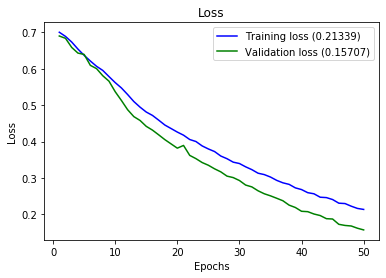

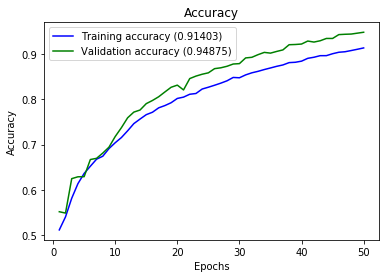

In [8]:
plot_history(history)

In [9]:
hotdogs = glob.glob('./hot-dog-not-hot-dog/test/hot_dog/**/*.jpg', recursive=True) 
notHotdogs = glob.glob('./hot-dog-not-hot-dog/test/not_hot_dog/**/*.jpg', recursive=True)

scaled_X_test, y_test = loadData(size, 250, hotdogs, notHotdogs)
scaled_X_test = preprocessData(scaled_X_test)

#get the predictions for the test data
predicted_classes = model.predict_classes(scaled_X_test)

# setup the true classes: just 250 hotdogs followed by 250 not hotdogs
y_true = np.concatenate((np.zeros((250,)), np.ones((250,))))
from sklearn.metrics import classification_report
print(classification_report(y_true, predicted_classes, target_names=['hotdog', 'not hotdog']))

There are 250 hotdog images
There are 250 not hotdog images
              precision    recall  f1-score   support

      hotdog       0.98      0.91      0.94       250
  not hotdog       0.91      0.98      0.95       250

    accuracy                           0.94       500
   macro avg       0.95      0.94      0.94       500
weighted avg       0.95      0.94      0.94       500



In [10]:
accuracy_score(y_true, predicted_classes)

0.944